In [13]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [14]:
import numpy as np
import pandas as pd

In [15]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [37]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [17]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [18]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [19]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [20]:
# Save references to classes
Measurement = Base.classes.measurement
Station = Base.classes.station

In [38]:
# Inspect measurement class
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [39]:
#inspect station class
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [21]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [22]:
# Examine at measurement table
precip_data = session.query(Measurement).first()
precip_data.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x298ee6e1b00>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

###### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [29]:
# Calculate the date 1 year ago from the last data point in the database
max_date = session.query(func.max(func.strftime("%Y-%m-%d", Measurement.date))).limit(5).all()
max_date

[('2017-08-23')]

In [40]:
# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

In [83]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_data, columns = ['date', 'precipitation'])

# Set date as index
precip_df.set_index('date', inplace = True)

# Check data
precip_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [42]:
# Sort the dataframe by date
precip_df = precip_df.sort_values(by = 'date')
precip_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


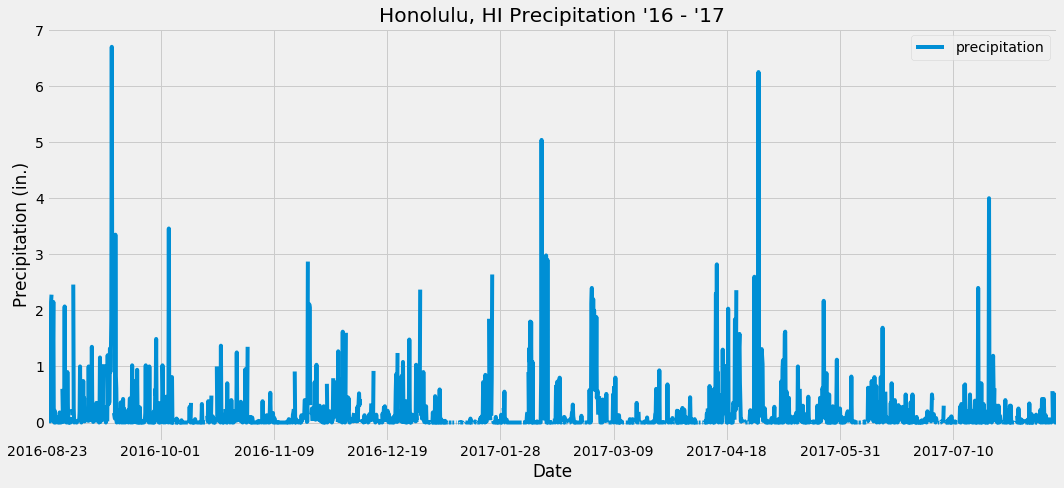

In [82]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize = (15, 7))
precip_df.plot(ax = ax, x_compat = True)

# Set title and labels
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (in.)')
ax.set_title("Honolulu, HI Precipitation '16 - '17")

# Save figure
plt.savefig("Images/precipitation")

# Display figure
plt.tight_layout()
plt.show()

In [44]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [46]:
# Design a query to show how many stations are available in this dataset?
num_of_stations = session.query(Station.id).distinct().count()
num_of_stations

9

In [48]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_counts = session.query(Station.station, func.count(Measurement.id)).select_from(Measurement).\
    join(Station, Measurement.station == Station.station).group_by(Station.station).\
    order_by(func.count(Measurement.id).desc()).all()

for result in station_counts:
    print(f"Station: {result[0]}\tCount: {result[1]}")

Station: USC00519281	Count: 2772
Station: USC00519397	Count: 2724
Station: USC00513117	Count: 2709
Station: USC00519523	Count: 2669
Station: USC00516128	Count: 2612
Station: USC00514830	Count: 2202
Station: USC00511918	Count: 1979
Station: USC00517948	Count: 1372
Station: USC00518838	Count: 511


In [58]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = 'USC00519281'
summary_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), \
    func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
print(f"Lowest Temperature: {summary_temps[0][0]} Fahrenheit")
print(f"Highest Temperature: {summary_temps[0][1]} Fahrenheit")
print(f"Average Temperature: {round(summary_temps[0][2], 2)} Fahrenheit")

Lowest Temperature: 54.0 Fahrenheit
Highest Temperature: 85.0 Fahrenheit
Average Temperature: 71.66 Fahrenheit


In [59]:
# Get temperature data for most active station over final 12 months of data
yearly_temps = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

# Store in dataframe
yearly_temps_df = pd.DataFrame(yearly_temps, columns = ['date', 'temperature'])
yearly_temps_df.head()

,date,temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


In [60]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
#   and plot the results as a histogram
# Set index to date
yearly_temps_df.set_index('date', inplace = True)

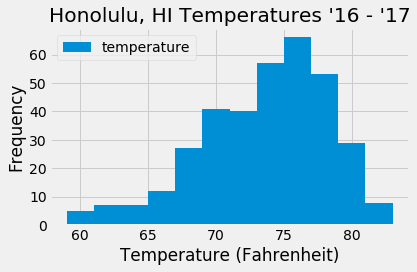

In [85]:
# Plot the histogram
fig, ax = plt.subplots()
yearly_temps_df.plot.hist(bins = 12, ax = ax)

# Set labels and legend
ax.set_xlabel('Temperature (Fahrenheit)')
ax.set_ylabel('Frequency')
ax.set_title("Honolulu, HI Temperatures '16 - '17")

# Save chart
plt.savefig("Images/station_histogram")

# Display chart
plt.tight_layout()
plt.show()

In [86]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [87]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#Now, we can apply the function to our trip time.
trip_temps = calc_temps('2016-11-09', '2016-11-22')

print(f"Lowest Temperature: {trip_temps[0][0]} Fahrenheit")
print(f"Average Temperature: {round(trip_temps[0][1], 2)} Fahrenheit")
print(f"Highest Temperature: {trip_temps[0][2]} Fahrenheit")

Lowest Temperature: 67.0 Fahrenheit
Average Temperature: 74.74 Fahrenheit
Highest Temperature: 80.0 Fahrenheit


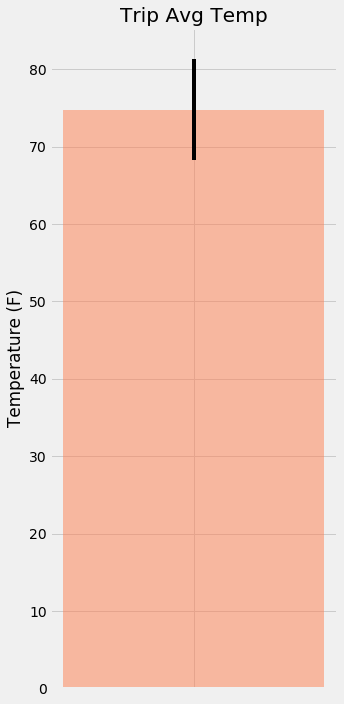

In [88]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

pk_to_pk = trip_temps[0][2] - trip_temps[0][0]
avg_temp = trip_temps[0][1]

# Plot the chart
fig, ax = plt.subplots(figsize = (5, 10))

ax.bar(1, avg_temp, yerr = pk_to_pk/2, width = 0.4, color = "coral", alpha=0.5)

# Set labels and legends
ax.set_xticks([1])
ax.set_xticklabels([""])
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temperature (F)')

# Save chart
plt.savefig("Images/temperature")

# Display chart
plt.tight_layout()
plt.show()

In [80]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
yearly_rainfall = session.query(Station.station, Station.name, Station.latitude,  \
    Station.longitude, Station.elevation, func.avg(Measurement.prcp)).            \
    filter(Measurement.station == Station.station).                               \
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).  \
    group_by(Station.station).order_by(func.avg(Measurement.prcp).desc()).all()

# Assign to dataframe
yearly_rainfall_df = pd.DataFrame(yearly_rainfall, columns = \
    ['Station', 'Name', 'Latitude', 'Longitude', 'Elevation', 'Avg. Precipitation (in.)'])

yearly_rainfall_df

,Station,Name,Latitude,Longitude,Elevation,Avg. Precipitation (in.)
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.450640
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.198949
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.141429
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.125434
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.121051
5,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.076500
6,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.044819


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching 
#  a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


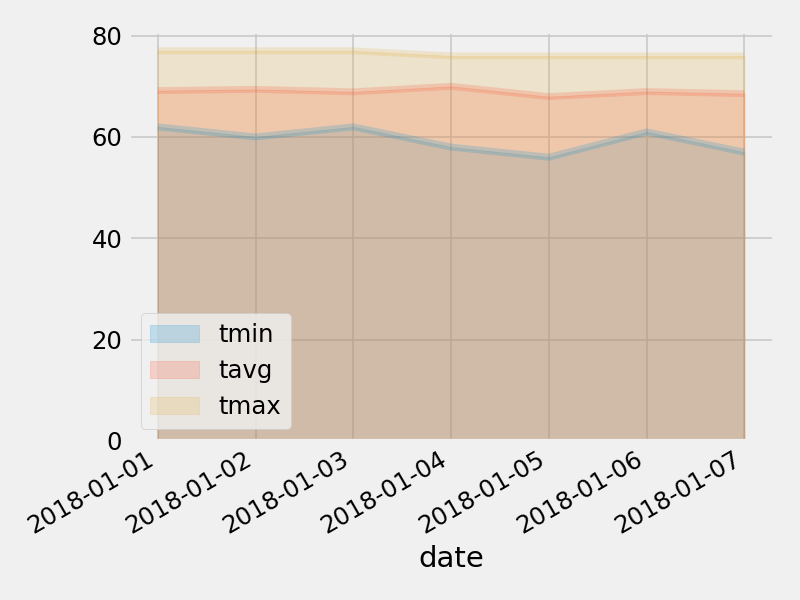

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
